Here we will look at how the simulations project in typical IC / EC gate space

In [1]:
import matplotlib.pyplot as plt
import MDAnalysis as mda
import matplotlib as mpl
import numpy as np
from MDAnalysis.analysis import distances as d

import sys
sys.path.append('../') ## to get src lib
import src.analysis_functions as analysis_functions
import src.simulation_metadata as sims
from src.figure_parameters import figure_rc_params


In [2]:
sim_list = [sims.PfHT_MMV12]
color_l = [sim.color for sim in sim_list]

sim = sim_list[0]

all_unis, all_lens = analysis_functions.load_unis(
    sim_list= sim_list
)

## can add 22 to resids here, so that we don't have to do counting!! Amazing
for sim in sim_list:
    for u_rep in all_unis[sim.name]:
        u_rep.add_TopologyAttr('resid', list(range(22, len(u_rep.residues)+22)))



In [6]:
def get_gate_arr(
        sim: sims.SimulationMetadata,
        tm1_s: str='resid 44-49',
        tm7_s: str='resid 310-318',
        tm4_s: str='resid 145-153',
        tm10_s: str='resid 409-416',
        com: bool=True,
) -> np.array:
    ''' 
    calculate minimum distance between either all atoms in gate (com=False)
    or the min distance between centers of mass 
    return a np array with shape [n_replicas, 2, n_frames]
    where array[n,:,0] is ic gate and array[n,:,1] is ec gate    
    '''

    dists = np.zeros((sim.n_replicas,2000,2))
    dists[:] = np.nan

    for n,u_rep in enumerate(all_unis[sim.name]):
        tm1 = u_rep.select_atoms(tm1_s)
        tm7 = u_rep.select_atoms(tm7_s)
        tm4 = u_rep.select_atoms(tm4_s)
        tm10 = u_rep.select_atoms(tm10_s)

        for ts in u_rep.trajectory:
            if com:
                tm1_d = tm1.center_of_mass()
                tm7_d = tm7.center_of_mass()
                tm4_d = tm4.center_of_mass()
                tm10_d = tm10.center_of_mass()
            else:
                tm1_d = tm1.positions
                tm7_d = tm7.positions
                tm4_d = tm4.positions
                tm10_d = tm10.positions

            ec_gate = np.min(d.distance_array(tm1_d, tm7_d))
            ic_gate = np.min(d.distance_array(tm4_d, tm10_d))
            dists[n,ts.frame,0] = ic_gate
            dists[n,ts.frame,1] = ec_gate
    
    return dists



(7.0, 18.0)

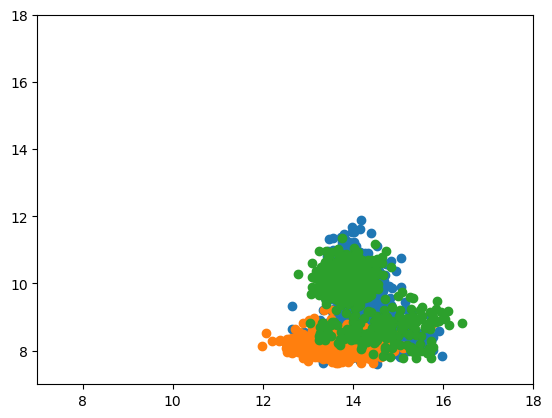

In [12]:
dists = get_gate_arr(sim, 
                     com=True)

f,ax = plt.subplots(1,1)

for rep in dists:
    ax.scatter(rep[:,0], rep[:,1])

ax.set_xlim(7, 18)
ax.set_ylim(7, 18)